# How to backtest chart patterns with VectorBT PRO

VectorBT PRO (https://vectorbt.pro/) is a proprietary Python package designed for backtesting and analyzing quantitative trading strategies. It provides a comprehensive suite of tools for every stage of an algorithmic trading workflow, including data acquisition, signal generation and analysis, portfolio optimization, strategy simulation, hyperparameter tuning, and cross-validation. These modular components empower users to flexibly customize their analysis, setting it apart from monolithic backtesting frameworks.

One of these components is a data pattern detector that efficiently scans data using variable-length windows, assessing their similarity to a specified pattern. This process, optimized with Numba (https://numba.pydata.org/), operates on any hardware without the need for machine learning. To showcase the detector's capabilities, we will conduct backtesting on a range of patterns and their combinations on a single dataset.

## Imports and set up

Due to VectorBT PRO's self-contained design, only minimal imports are necessary.

In [1]:
from vectorbtpro import *

# whats_imported()

vbt.settings.set_theme("dark")

VectorBT PRO features built-in data downloading from sources such as Yahoo Finance, Alpaca, Polygon, TradingView, and many more. We will perform pattern detection on hourly price data pulled from TradingView.

In [2]:
symbols = [
    "NASDAQ:META",
    "NASDAQ:AMZN",
    "NASDAQ:AAPL",
    "NASDAQ:NFLX",
    "NASDAQ:GOOG",
]

data = vbt.TVData.pull(symbols, timeframe="hourly")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/olegpolakow/Documents/GitHub/vectorbt.pro/vectorbtpro/data/base.py:1565: UserWarning: Symbols have mismatching index. Setting missing data points to NaN.
  data = cls_or_self.align_index(data, missing=missing_index, silence_warnings=silence_warnings)


TradingView does not offer the option to specify a date range in advance, so we will need to select it afterward.

In [3]:
start_date = "2020"
end_date = None

data = data.xloc[start_date:end_date]

Ensure that our data spans the correct date period and is free of NaN values.

In [4]:
print(data.stats())

Start                       2020-01-02 14:30:00+00:00
End                         2023-09-22 19:30:00+00:00
Period                              273 days 08:00:00
Total Symbols                                       5
Null Counts: NASDAQ:META                           35
Null Counts: NASDAQ:AMZN                           25
Null Counts: NASDAQ:AAPL                           15
Null Counts: NASDAQ:NFLX                           40
Null Counts: NASDAQ:GOOG                           40
Name: agg_stats, dtype: object


As pattern detection requires only a single time series, we must choose the suitable feature. We'll utilize HLC/3, which effectively captures price fluctuations.

In [5]:
price = data.hlc3

## Define patterns

Numerous chart patterns can be translated into numerical sequences, like the "Double Top" pattern (https://www.investopedia.com/terms/d/doubletop.asp) represented as [1, 3, 2, 3, 1]. It's important to note that while the numbers themselves can be arbitrary, their relative spacing should mirror the relative distance between the pattern's chart points. For instance, in this sequence, 2 aligns with the midpoint between valley point 1 and peak point 3. The same principle applies to temporal distribution: points should be equidistant from one another.

In [6]:
bullish_patterns = {
    "double_bottom": [5, 1, 3, 1, 5],
    "exp_triangle": [3, 4, 2, 5, 1, 6],
    "asc_triangle": [1, 5, 2, 5, 3, 6],
    "symm_triangle": [1, 6, 2, 5, 3, 6],
    "pennant": [6, 1, 5, 2, 4, 3, 6],
}
bearish_patterns = {
    "head_and_shoulders": [1, 4, 2, 6, 2, 4, 1],
    "double_top": [1, 5, 3, 5, 1],
    "desc_triangle": [6, 2, 5, 2, 4, 1],
    "symm_triangle": [6, 1, 5, 2, 4, 1],
    "pennant": [1, 6, 2, 5, 3, 4, 1],
}

Confirm the visual representation of a pattern by plotting its corresponding line graph.

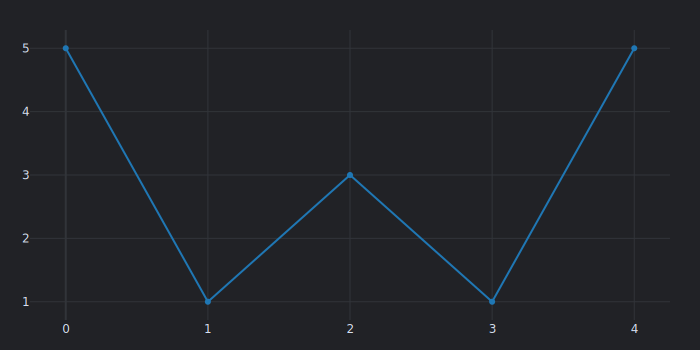

In [22]:
pd.Series(bullish_patterns["double_bottom"]).vbt.plot().show_svg()

Each generated sequence serves as a rough approximation of the desired chart pattern, and there's no need for precise adjustments: VectorBT PRO's similarity-based algorithm is flexible and can identify patterns, even if they are not perfectly consistent in their design.

## Detect patterns in data

Iterate through each pattern, dataset, and timestamp within the dataset. Search for matches within windows spanning from 1 to 30 days, and create a record for each match that exceeds a pre-defined minimum similarity score, which is set by default to 85%.

In [8]:
min_window = 24
max_window = 24 * 30


def detect_patterns(patterns):
    return vbt.PatternRanges.from_pattern_search(
        price,
        open=data.open,  # OHLC for plotting
        high=data.high,
        low=data.low,
        close=data.close,
        pattern=patterns,
        window=min_window,
        max_window=max_window,
        execute_kwargs=dict(  # multithreading
            engine="threadpool",
            chunk_len="auto",
        ),
    )


bullish_matches = detect_patterns(vbt.Param(bullish_patterns, name="bullish_pattern"))
bearish_matches = detect_patterns(vbt.Param(bearish_patterns, name="bearish_pattern"))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In just several minutes, VectorBT PRO seamlessly detected matches among all patterns. This process, involving around 230 million unique pattern and window combinations, was executed in parallel.

Get the number of matches for each pattern and dataset.

In [9]:
print(bullish_matches.count())

bullish_pattern  symbol     
double_bottom    NASDAQ:META     5
                 NASDAQ:AMZN    14
                 NASDAQ:AAPL     6
                 NASDAQ:NFLX    10
                 NASDAQ:GOOG    11
exp_triangle     NASDAQ:META     0
                 NASDAQ:AMZN     0
                 NASDAQ:AAPL     4
                 NASDAQ:NFLX     0
                 NASDAQ:GOOG     2
asc_triangle     NASDAQ:META     4
                 NASDAQ:AMZN     4
                 NASDAQ:AAPL    10
                 NASDAQ:NFLX     6
                 NASDAQ:GOOG     4
symm_triangle    NASDAQ:META     1
                 NASDAQ:AMZN     1
                 NASDAQ:AAPL     3
                 NASDAQ:NFLX     1
                 NASDAQ:GOOG     3
pennant          NASDAQ:META     1
                 NASDAQ:AMZN     0
                 NASDAQ:AAPL     2
                 NASDAQ:NFLX     0
                 NASDAQ:GOOG     0
Name: count, dtype: int64


Plot the pattern and dataset with the most matches.

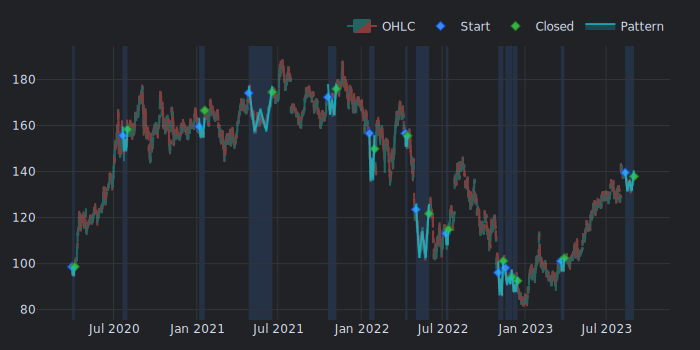

In [10]:
vbt.settings.plotting.auto_rangebreaks = True  # for stocks

display_column = bullish_matches.count().idxmax()

bullish_matches.plot(column=display_column, fit_ranges=True).show_svg()

Zoom in on a match.

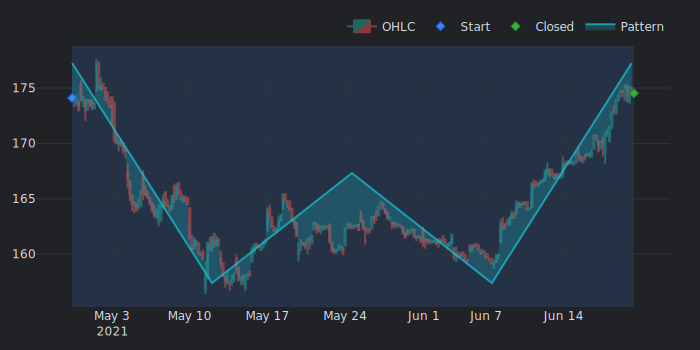

In [21]:
display_match = 3

bullish_matches.plot(column=display_column, fit_ranges=display_match).show_svg()

The window data closely aligns with the pattern. This functionality is highly comprehensive, offering the flexibility to adjust fitness levels, modify rescaling and interpolation algorithms, and more to suit specific requirements.

## Transform matches to signals

To conduct backtesting on the identified patterns, we will convert them into signals, triggering a signal once a pattern has fully developed.

In [12]:
entries = bullish_matches.last_pd_mask
exits = bearish_matches.last_pd_mask

Generate a Cartesian product of bullish and bearish patterns to systematically test each bullish pattern against each bearish pattern.

In [13]:
entries, exits = entries.vbt.x(exits)

Both arrays have been converted into equally-shaped DataFrames, each comprising 125 columns. Each column represents an individual backtest, encompassing three parameters: bullish pattern, bearish pattern, and symbol.

In [14]:
print(entries.columns)

MultiIndex([('double_bottom', 'head_and_shoulders', 'NASDAQ:META'),
            ('double_bottom', 'head_and_shoulders', 'NASDAQ:AMZN'),
            ('double_bottom', 'head_and_shoulders', 'NASDAQ:AAPL'),
            ('double_bottom', 'head_and_shoulders', 'NASDAQ:NFLX'),
            ('double_bottom', 'head_and_shoulders', 'NASDAQ:GOOG'),
            ('double_bottom',         'double_top', 'NASDAQ:META'),
            ('double_bottom',         'double_top', 'NASDAQ:AMZN'),
            ('double_bottom',         'double_top', 'NASDAQ:AAPL'),
            ('double_bottom',         'double_top', 'NASDAQ:NFLX'),
            ('double_bottom',         'double_top', 'NASDAQ:GOOG'),
            ...
            (      'pennant',      'symm_triangle', 'NASDAQ:META'),
            (      'pennant',      'symm_triangle', 'NASDAQ:AMZN'),
            (      'pennant',      'symm_triangle', 'NASDAQ:AAPL'),
            (      'pennant',      'symm_triangle', 'NASDAQ:NFLX'),
            (      'pennant',   

## Backtest signals

Establish a portfolio by simulating signals.

In [15]:
pf = vbt.Portfolio.from_signals(data, entries, exits)

Get the mean total return for every combination of bullish and bearish patterns.

In [16]:
mean_total_return = pf.total_return.groupby(["bullish_pattern", "bearish_pattern"]).mean()

print(mean_total_return)

bullish_pattern  bearish_pattern   
asc_triangle     desc_triangle         0.141544
                 double_top            0.078194
                 head_and_shoulders    0.382325
                 pennant               0.340322
                 symm_triangle         0.488653
double_bottom    desc_triangle         0.332584
                 double_top            0.164022
                 head_and_shoulders    0.361569
                 pennant               0.342995
                 symm_triangle         0.463775
exp_triangle     desc_triangle         0.196349
                 double_top            0.058434
                 head_and_shoulders    0.323352
                 pennant               0.305847
                 symm_triangle         0.384134
pennant          desc_triangle         0.351857
                 double_top            0.253997
                 head_and_shoulders    0.357806
                 pennant               0.394544
                 symm_triangle         0.394544
symm

As visual beings, let's represent these values as a heatmap.

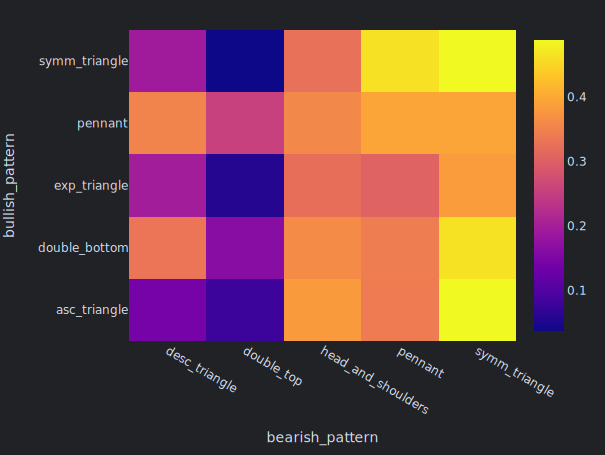

In [17]:
mean_total_return.vbt.heatmap(x_level="bearish_pattern", y_level="bullish_pattern").show_svg()

Although the displayed performance of each pattern combination does not guarantee future results, it provides insight into how the market responded to pattern events in the past. For instance, it's noteworthy that the "Bearish Symmetrical Triangle" exhibited a notably bullish trend. Cross-validation and robustness testing are next essential steps for a comprehensive assessment.

Read more at https://vectorbt.pro/tutorials/patterns-and-projections/